## Análisis de datos - Clase 6

---
### Técnicas de selección de features
---

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split


#### Para este ejemplo usamos el dataset 'adult' que tiene información capturada durante un censo. El objetivo es, dado un conjunto de características de adultos, predecir si su rango salarial estará por encima de 50K (problema de clasificación binaria).

In [86]:
# Cargar el dataset de censo de adultos
adultos = fetch_openml(name='adult', version=2, as_frame=True)
X = adultos.data
y = adultos.target

In [87]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.6 MB


In [89]:
X.isna().mean().round(4)*100

age               0.00
workclass         5.73
fnlwgt            0.00
education         0.00
education-num     0.00
marital-status    0.00
occupation        5.75
relationship      0.00
race              0.00
sex               0.00
capital-gain      0.00
capital-loss      0.00
hours-per-week    0.00
native-country    1.75
dtype: float64

In [90]:
y.head()

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['<=50K', '>50K']

In [91]:
X['education'].value_counts()

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

In [92]:
# Definir características
num_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
nominal_features = [f for f in cat_features if f != 'education'] # Son todos nominales menos "education"
education_levels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
                    'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 
                    'Prof-school', 'Doctorate']

---
#### Paso 1: Dividir en train y test
---

In [93]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño train:", X_train.shape, "Test:", X_test.shape)

Tamaño train: (39073, 14) Test: (9769, 14)


---
#### Paso 2: Imputación
---

In [94]:
# Imputar numéricas con mediana (fit en train, transformar ambos)
num_imputer = SimpleImputer(strategy='median')
X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
X_test[num_features] = num_imputer.transform(X_test[num_features])


In [95]:
# Imputar categóricas con moda (fit en train, transformar ambos)
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

---
#### Paso 3: Codificación
---

In [96]:
# Variable target (y) con OrdinalEncoder
oe_target = OrdinalEncoder(categories=[['<=50K', '>50K']])
y_train_encoded = oe_target.fit_transform(y_train.to_frame()).ravel()
y_test_encoded = oe_target.transform(y_test.to_frame()).ravel()
print("\nClases objetivo:", oe_target.categories_[0])

# Nominales con BinaryEncoder (Podría haber usado OHE, pero me iban a quedar muchas columnas)
be = BinaryEncoder(cols=nominal_features)
X_train_cat = be.fit_transform(X_train[nominal_features])
X_test_cat = be.transform(X_test[nominal_features])


Clases objetivo: ['<=50K' '>50K']


In [97]:
X_train_cat.shape

(39073, 25)

In [98]:
X_train_cat.head()

,workclass_0,workclass_1,workclass_2,workclass_3,marital-status_0,marital-status_1,marital-status_2,occupation_0,occupation_1,occupation_2,...,race_1,race_2,sex_0,sex_1,native-country_0,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5
37193,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
31093,0,0,1,0,0,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,1
33814,0,0,1,1,0,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,1
14500,0,0,0,1,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
23399,0,0,0,1,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1


---
#### Paso 4: Normalización 
---

In [99]:
scaler = MinMaxScaler()

X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num = scaler.transform(X_test[num_features])
X_train_num = pd.DataFrame(X_train_num, columns=num_features, index=X_train.index)
X_test_num = pd.DataFrame(X_test_num, columns=num_features, index=X_test.index)

# Combinar todas las variables
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [100]:
X_train_final.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_0,workclass_1,workclass_2,workclass_3,...,race_1,race_2,sex_0,sex_1,native-country_0,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5
37193,0.342466,0.090253,0.600000,0.0,0.0,0.397959,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1
31093,0.479452,0.110528,0.333333,0.0,0.0,0.346939,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
33814,0.232877,0.108922,0.533333,0.0,0.0,0.397959,0,0,1,1,...,0,1,0,1,0,0,0,0,0,1
14500,0.150685,0.077088,0.533333,0.0,0.0,0.397959,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
23399,0.397260,0.010957,0.666667,0.0,0.0,0.500000,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1


---
#### Ahora el dataset está listo para aplicar filtros y seleccionar features.
---

#### 1. Correlación 

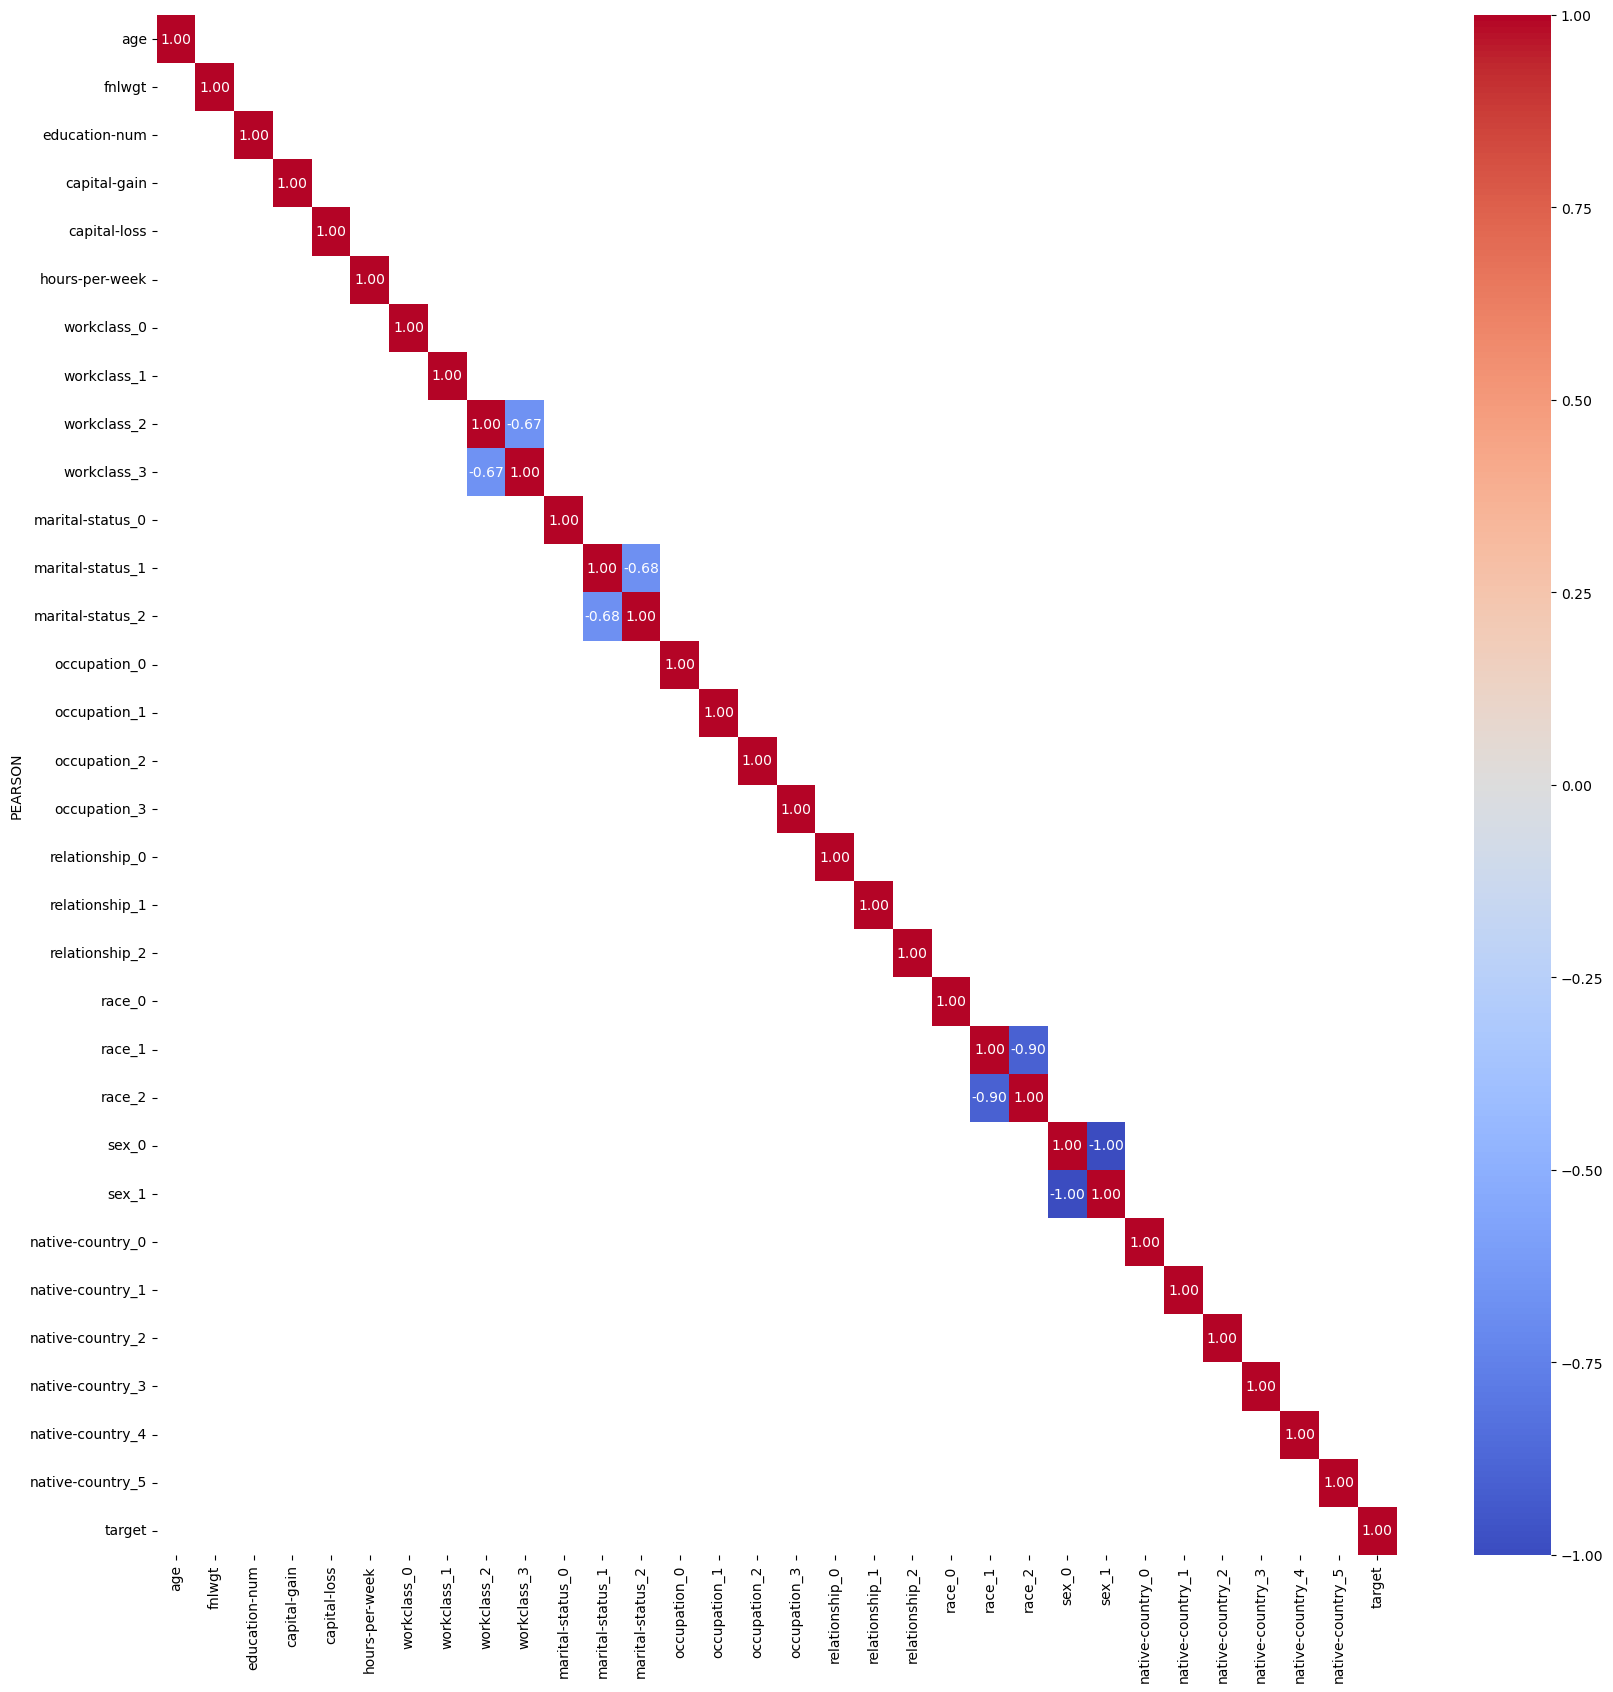

In [101]:
datos_train_corr = X_train_final.copy()
datos_train_corr['target'] = y_train_encoded.copy()


umbral = 0.65
mask_for_heatmap = (datos_train_corr.corr(method='kendall').abs() < umbral)
plt.figure(figsize=(20,20))
sns.heatmap(
    datos_train_corr.corr(method='kendall'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.ylabel('PEARSON')
plt.show()

#### 2. Umbral de varianza

In [102]:
X_train_final.var()

age                 0.035343
fnlwgt              0.005125
education-num       0.029394
capital-gain        0.005522
capital-loss        0.008695
hours-per-week      0.016160
workclass_0         0.000230
workclass_1         0.094287
workclass_2         0.149606
workclass_3         0.126283
marital-status_0    0.069823
marital-status_1    0.249523
marital-status_2    0.233791
occupation_0        0.182291
occupation_1        0.249736
occupation_2        0.235206
occupation_3        0.248868
relationship_0      0.212555
relationship_1      0.222633
relationship_2      0.248324
race_0              0.038167
race_1              0.092830
race_2              0.091650
sex_0               0.221452
sex_1               0.221452
native-country_0    0.008626
native-country_1    0.017767
native-country_2    0.030537
native-country_3    0.031782
native-country_4    0.049898
native-country_5    0.047071
dtype: float64

In [103]:
selector = VarianceThreshold(threshold=0.02) 
X_train_selected = selector.fit_transform(X_train_final)
print("\nCaracterísticas seleccionadas (varianza):", X_train_final.columns[selector.get_support()].tolist())

# Aplico la selección también a test
X_test_selected = selector.transform(X_test_final)



Características seleccionadas (varianza): ['age', 'education-num', 'workclass_1', 'workclass_2', 'workclass_3', 'marital-status_0', 'marital-status_1', 'marital-status_2', 'occupation_0', 'occupation_1', 'occupation_2', 'occupation_3', 'relationship_0', 'relationship_1', 'relationship_2', 'race_0', 'race_1', 'race_2', 'sex_0', 'sex_1', 'native-country_2', 'native-country_3', 'native-country_4', 'native-country_5']


#### 3. ANOVA

#### Analizamos el poder predictivo que tienen las variables numéricas sobre la variable target.



In [104]:
# ANOVA (numéricas, fit en train, transformar ambos)
selector_anova = SelectKBest(score_func=f_classif, k=3) # usar f_regression para categórica -> numérica
X_train_num_best = selector_anova.fit_transform(X_train_num, y_train_encoded)
selected_indices = selector_anova.get_support() # Esta función me devuelve los features seleccionados
selected_features = X_train_num.columns[selected_indices]
scores = selector_anova.scores_[selected_indices]
print(f"Numéricas antes de filtrar: {X_train_num.columns}")
print("\nCaracterísticas seleccionadas (ANOVA):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

# Aplicar el filtro a los datos de test:
X_test_num_best = selector_anova.transform(X_test_num)

Numéricas antes de filtrar: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

Características seleccionadas (ANOVA):
age: 2241.2623
education-num: 4892.3314
hours-per-week: 2119.3098



#### 4. Chi-cuadrado


#### Identificar la relación entre las categóricas de entrada y la variable categórica de salida 

In [105]:
# Chi-Square (categóricas, fit en train, transformar ambos)
selector_chi2 = SelectKBest(score_func=chi2, k=5)
X_train_cat_best = selector_chi2.fit_transform(X_train_cat, y_train_encoded)
selected_indices = selector_chi2.get_support()
selected_features = X_train_cat.columns[selected_indices]
scores = selector_chi2.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Chi-Square):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

# Aplicar el filtro a test
X_test_cat_best = selector_chi2.transform(X_test_cat)


Características seleccionadas (Chi-Square):
marital-status_1: 3214.9763
marital-status_2: 1742.1710
relationship_0: 1279.5575
relationship_2: 1397.6895
sex_0: 1187.0050



#### 5. Información mutua


In [106]:
# Información mutua (todas, fit en train, transformar ambos)
selector_mi = SelectKBest(score_func=mutual_info_classif, k=10) # también se puede usar mutual_info_regression para problemas de ese tipo
X_train_best = selector_mi.fit_transform(X_train_final, y_train_encoded) # todos los tipos de features
selected_indices = selector_mi.get_support()
selected_features = X_train_final.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

X_test_best = selector_mi.transform(X_test_final)


Características seleccionadas (Inf. mutua):
age: 0.0684
fnlwgt: 0.0321
education-num: 0.0642
capital-gain: 0.0843
capital-loss: 0.0350
hours-per-week: 0.0385
marital-status_1: 0.0901
marital-status_2: 0.0749
relationship_2: 0.0442
sex_0: 0.0310
